In [1]:
!python3 -m venv venv
!source venv/bin/activate

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
!pip install xgboost lightgbm

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 253.9/253.9 MB 33.4 MB/s eta 0:00:0000:0100:01
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3.6/3.6 MB 2.1 MB/s eta 0:00:00eta 0:00:01
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 322.5/322.5 MB 32.1 MB/s eta 0:00:0000:0100:01
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3/3 [lightgbm]2/3 [lightgbm]


In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np
!pip install missingno
import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score

import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
train_data_path = join('./data', 'train.csv')
sub_data_path = join('./data', 'test.csv')

## 1. Îç∞Ïù¥ÌÑ∞ ÏÇ¥Ìé¥Î≥¥Í∏∞
pandasÏùò read_csv Ìï®ÏàòÎ•º ÏÇ¨Ïö©Ìï¥ Îç∞Ïù¥ÌÑ∞Î•º ÏùΩÏñ¥Ïò§Í≥†, Í∞Å Î≥ÄÏàòÎì§Ïù¥ ÎÇòÌÉÄÎÇ¥Îäî ÏùòÎØ∏Î•º ÏÇ¥Ìé¥Î≥¥Í≤†ÏäµÎãàÎã§.
1. ID : ÏßëÏùÑ Íµ¨Î∂ÑÌïòÎäî Î≤àÌò∏
2. date : ÏßëÏùÑ Íµ¨Îß§Ìïú ÎÇ†Ïßú
3. price : ÌÉÄÍ≤ü Î≥ÄÏàòÏù∏ ÏßëÏùò Í∞ÄÍ≤©
4. bedrooms : Ïπ®Ïã§Ïùò Ïàò
5. bathrooms : Ïπ®Ïã§Îãπ ÌôîÏû•Ïã§ Í∞úÏàò
6. sqft_living : Ï£ºÍ±∞ Í≥µÍ∞ÑÏùò ÌèâÎ∞© ÌîºÌä∏
7. sqft_lot : Î∂ÄÏßÄÏùò ÌèâÎ∞© ÌîºÌä∏
8. floors : ÏßëÏùò Ï∏µ Ïàò
9. waterfront : ÏßëÏùò Ï†ÑÎ∞©Ïóê Í∞ïÏù¥ ÌùêÎ•¥ÎäîÏßÄ Ïú†Î¨¥ (a.k.a. Î¶¨Î≤ÑÎ∑∞)
10. view : ÏßëÏù¥ ÏñºÎßàÎÇò Ï¢ãÏïÑ Î≥¥Ïù¥ÎäîÏßÄÏùò Ï†ïÎèÑ
11. condition : ÏßëÏùò Ï†ÑÎ∞òÏ†ÅÏù∏ ÏÉÅÌÉú
12. grade : King County grading ÏãúÏä§ÌÖú Í∏∞Ï§ÄÏúºÎ°ú Îß§Í∏¥ ÏßëÏùò Îì±Í∏â
13. sqft_above : ÏßÄÌïòÏã§ÏùÑ Ï†úÏô∏Ìïú ÌèâÎ∞© ÌîºÌä∏
14. sqft_basement : ÏßÄÌïòÏã§Ïùò ÌèâÎ∞© ÌîºÌä∏
15. yr_built : ÏßëÏùÑ ÏßÄÏùÄ ÎÖÑÎèÑ
16. yr_renovated : ÏßëÏùÑ Ïû¨Í±¥Ï∂ïÌïú ÎÖÑÎèÑ
17. zipcode : Ïö∞Ìé∏Î≤àÌò∏
18. lat : ÏúÑÎèÑ
19. long : Í≤ΩÎèÑ
20. sqft_living15 : 2015ÎÖÑ Í∏∞Ï§Ä Ï£ºÍ±∞ Í≥µÍ∞ÑÏùò ÌèâÎ∞© ÌîºÌä∏(ÏßëÏùÑ Ïû¨Í±¥Ï∂ïÌñàÎã§Î©¥, Î≥ÄÌôîÍ∞Ä ÏûàÏùÑ Ïàò ÏûàÏùå)
21. sqft_lot15 : 2015ÎÖÑ Í∏∞Ï§Ä Î∂ÄÏßÄÏùò ÌèâÎ∞© ÌîºÌä∏(ÏßëÏùÑ Ïû¨Í±¥Ï∂ïÌñàÎã§Î©¥, Î≥ÄÌôîÍ∞Ä ÏûàÏùÑ Ïàò ÏûàÏùå)

In [6]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [7]:
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)

In [8]:
y = data['price']

del data['price']

In [9]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [10]:
data.head()

id    date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0   0  201410         3       1.00         1180      5650     1.0           0   
1   1  201502         2       1.00          770     10000     1.0           0   
2   2  201502         3       2.00         1680      8080     1.0           0   
3   3  201406         3       2.25         1715      6819     2.0           0   
4   4  201501         3       1.50         1060      9711     1.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7        1180              0      1955             0   
1     0          3      6         770              0      1933             0   
2     0          3      8        1680              0      1987             0   
3     0          3      7        1715              0      1995             0   
4     0          3      7        1060              0      1963             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  
0    98178  47.5112 -122.257           1340        5650  
1    98028  47.7379 -122.233           2720        8062  
2    98074  47.6168 -122.045           1800        7503  
3    98003  47.3097 -122.327           2238        6819  
4    98198  47.4095 -122.315           1650        9711

## 2. Í∞ÑÎã®Ìïú Ï†ÑÏ≤òÎ¶¨ 
Í∞Å Î≥ÄÏàòÎì§Ïóê ÎåÄÌï¥ Í≤∞Ï∏° Ïú†Î¨¥Î•º ÌôïÏù∏ÌïòÍ≥†, Î∂ÑÌè¨Î•º ÌôïÏù∏Ìï¥Î≥¥Î©¥ÏÑú Í∞ÑÎã®ÌïòÍ≤å Ï†ÑÏ≤òÎ¶¨Î•º ÌïòÍ≤†ÏäµÎãàÎã§.
### Í≤∞Ï∏°Ïπò ÌôïÏù∏
Î®ºÏ†Ä Îç∞Ïù¥ÌÑ∞Ïóê Í≤∞Ï∏°ÏπòÍ∞Ä ÏûàÎäîÏßÄÎ•º ÌôïÏù∏ÌïòÍ≤†ÏäµÎãàÎã§.<br>
missingno ÎùºÏù¥Î∏åÎü¨Î¶¨Ïùò matrix Ìï®ÏàòÎ•º ÏÇ¨Ïö©ÌïòÎ©¥, Îç∞Ïù¥ÌÑ∞Ïùò Í≤∞Ï∏° ÏÉÅÌÉúÎ•º ÏãúÍ∞ÅÌôîÎ•º ÌÜµÌï¥ ÏÇ¥Ìé¥Î≥º Ïàò ÏûàÏäµÎãàÎã§.

<Axes: >

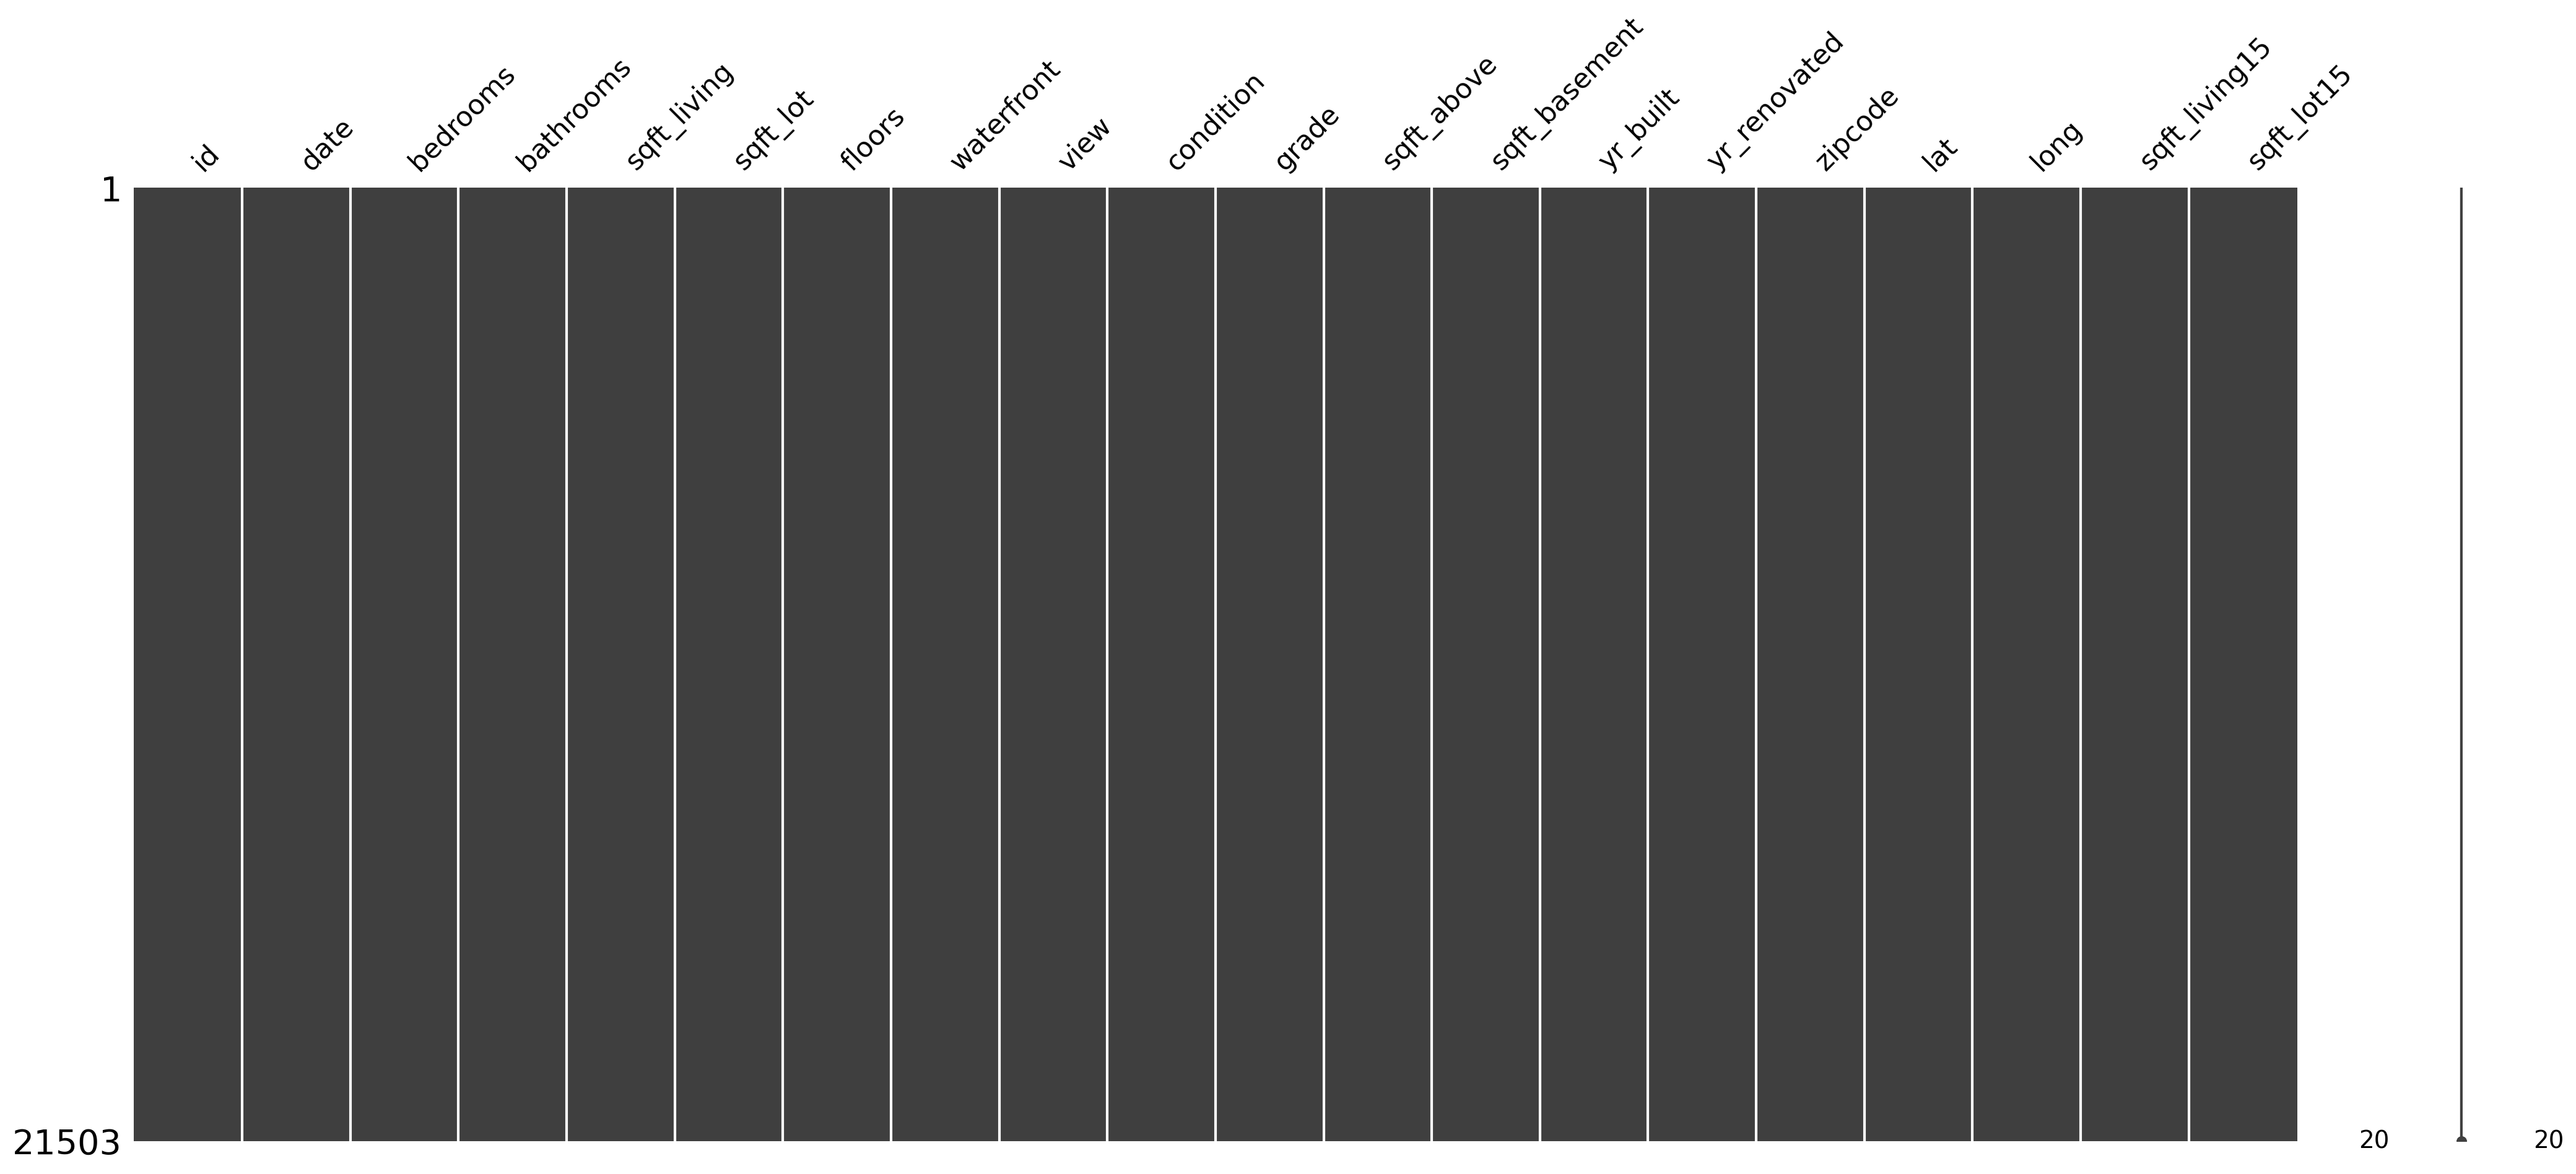

In [11]:
msno.matrix(data)

Î™®Îì† Î≥ÄÏàòÏóê Í≤∞Ï∏°ÏπòÍ∞Ä ÏóÜÎäî Í≤ÉÏúºÎ°ú Î≥¥Ïù¥ÏßÄÎßå, ÌòπÏãú Î™®Î•¥Îãà ÌôïÏã§ÌïòÍ≤å ÏÇ¥Ìé¥Î≥¥Í≤†ÏäµÎãàÎã§.<br>

In [12]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date Î≥ÄÏàò Ï†ïÎ¶¨
id Î≥ÄÏàòÎäî Î™®Îç∏Ïù¥ ÏßëÍ∞íÏùÑ ÏòàÏ∏°ÌïòÎäîÎç∞ ÎèÑÏõÄÏùÑ Ï£ºÏßÄ ÏïäÏúºÎØÄÎ°ú Ï†úÍ±∞Ìï©ÎãàÎã§.<br>
date Î≥ÄÏàòÎäî Ïó∞ÏõîÏùºÏãúÍ∞ÑÏúºÎ°ú Í∞íÏùÑ Í∞ÄÏßÄÍ≥† ÏûàÎäîÎç∞, Ïó∞ÏõîÎßå Í≥†Î†§ÌïòÎäî Î≤îÏ£ºÌòï Î≥ÄÏàòÎ°ú ÎßåÎì§Í≤†ÏäµÎãàÎã§.

In [13]:
sub_id = data['id'][train_len:]
del data['id']
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)

### Í∞Å Î≥ÄÏàòÎì§Ïùò Î∂ÑÌè¨ ÌôïÏù∏
ÌïúÏ™ΩÏúºÎ°ú ÏπòÏö∞Ïπú Î∂ÑÌè¨Îäî Î™®Îç∏Ïù¥ Í≤∞Í≥ºÎ•º ÏòàÏ∏°ÌïòÍ∏∞Ïóê Ï¢ãÏßÄ ÏïäÏùÄ ÏòÅÌñ•ÏùÑ ÎØ∏ÏπòÎØÄÎ°ú Îã§Îì¨Ïñ¥Ï§Ñ ÌïÑÏöîÍ∞Ä ÏûàÏäµÎãàÎã§.

In [15]:
data.dtypes

date              object
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

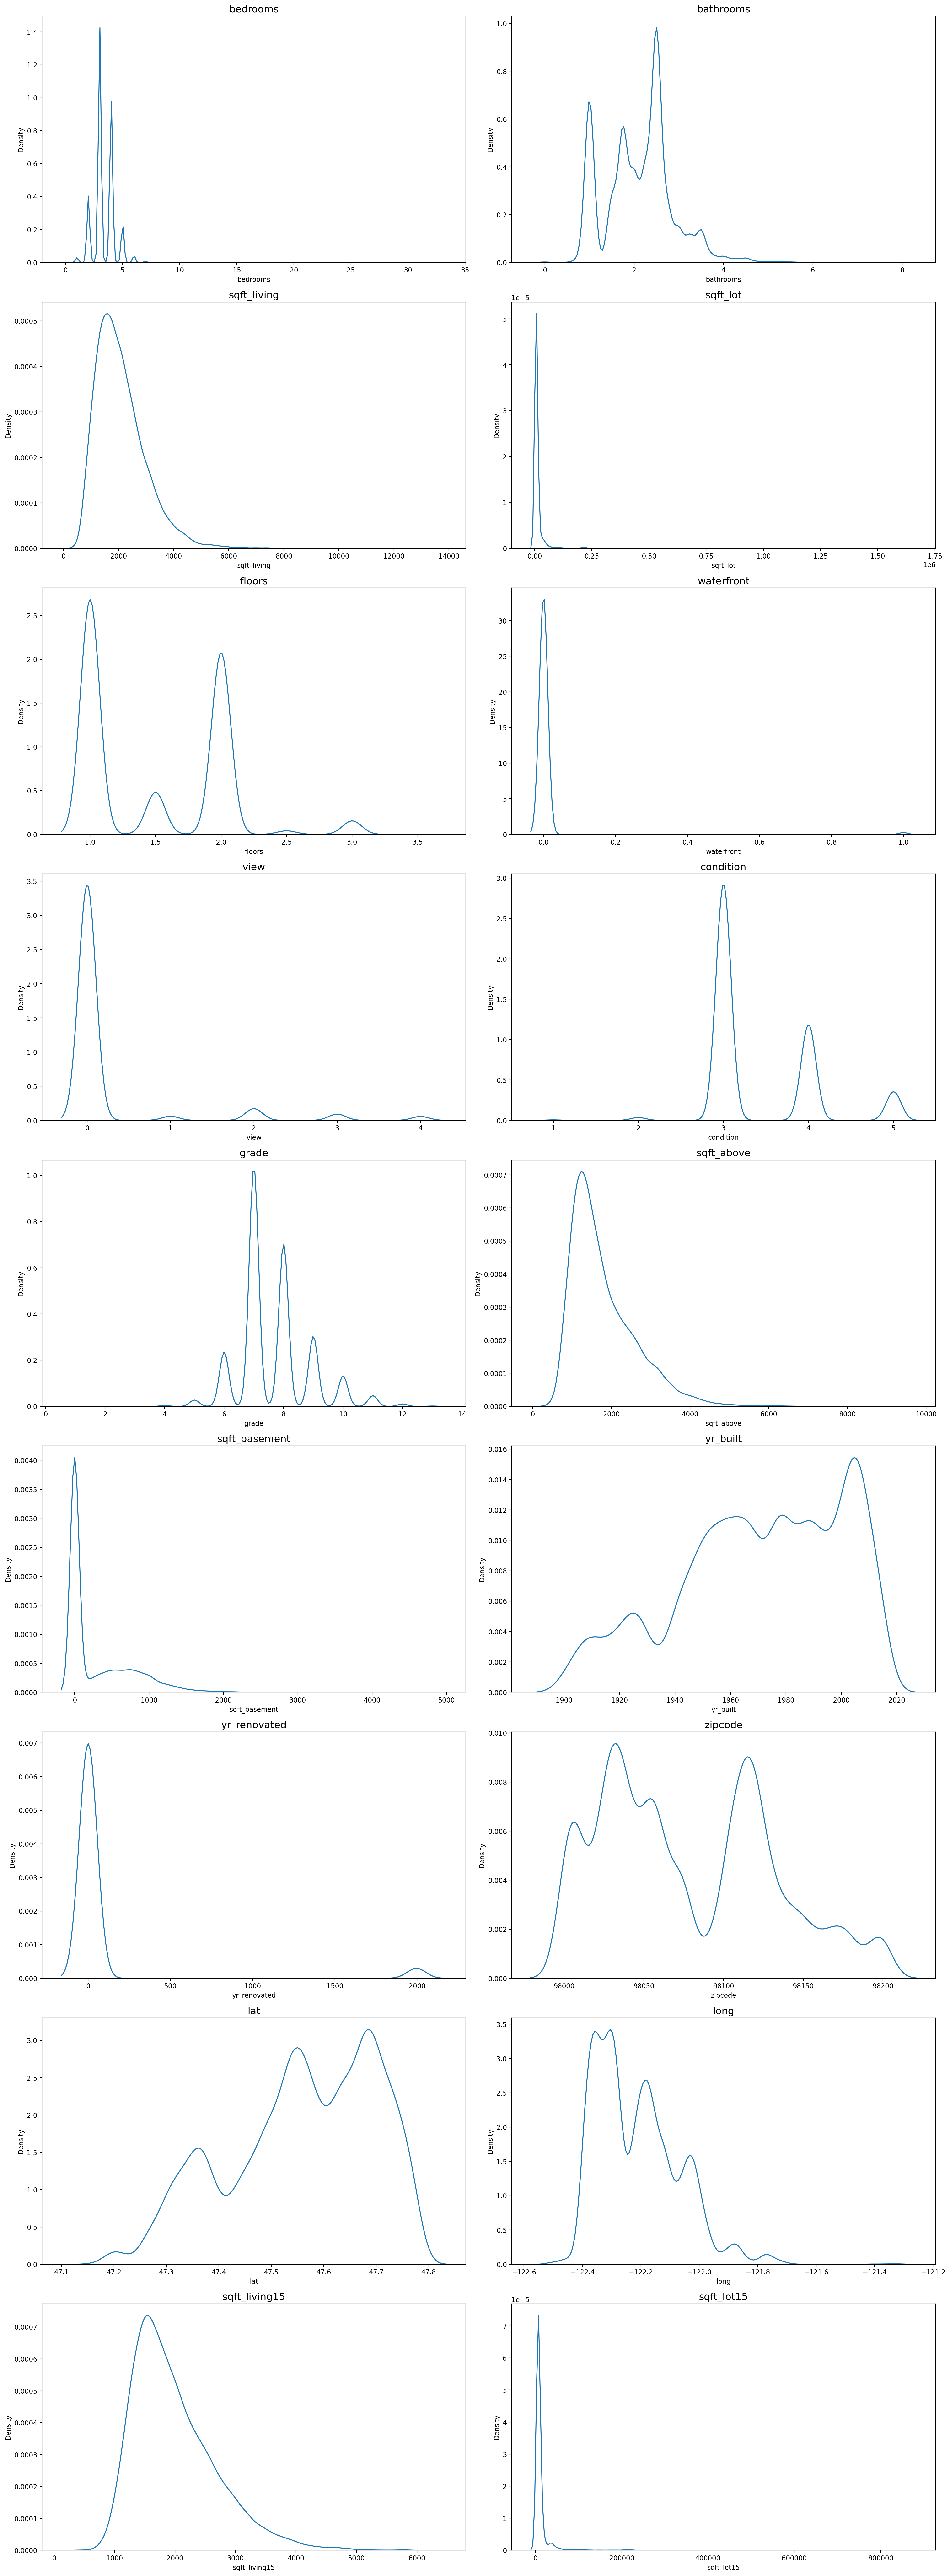

In [16]:
# Ïà´ÏûêÌòï Ïª¨ÎüºÎßå ÌïÑÌÑ∞ÎßÅ
numeric_cols = data.select_dtypes(include=['number']).columns.tolist()

# ÏÑúÎ∏åÌîåÎ°Ø ÌÅ¨Í∏∞ ÏûêÎèô Ï°∞Ï†ï (Ïª¨Îüº Í∞úÏàòÏóê Îî∞Îùº)
n_cols = 2
n_rows = (len(numeric_cols) + 1) // n_cols

fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 6))

count = 0
for row in range(n_rows):
    for col in range(n_cols):
        if count >= len(numeric_cols):
            break
        sns.kdeplot(data[numeric_cols[count]], ax=ax[row][col])
        ax[row][col].set_title(numeric_cols[count], fontsize=15)
        count += 1

plt.tight_layout()

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement Î≥ÄÏàòÍ∞Ä ÌïúÏ™ΩÏúºÎ°ú ÏπòÏö∞Ïπú Í≤ΩÌñ•ÏùÑ Î≥¥ÏòÄÏäµÎãàÎã§.<br>
log-scalingÏùÑ ÌÜµÌï¥ Îç∞Ïù¥ÌÑ∞ Î∂ÑÌè¨Î•º Ï†ïÍ∑úÎ∂ÑÌè¨Ïóê Í∞ÄÍπùÍ≤å ÎßåÎì§Ïñ¥ Î≥¥Í≤†ÏäµÎãàÎã§.

In [17]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

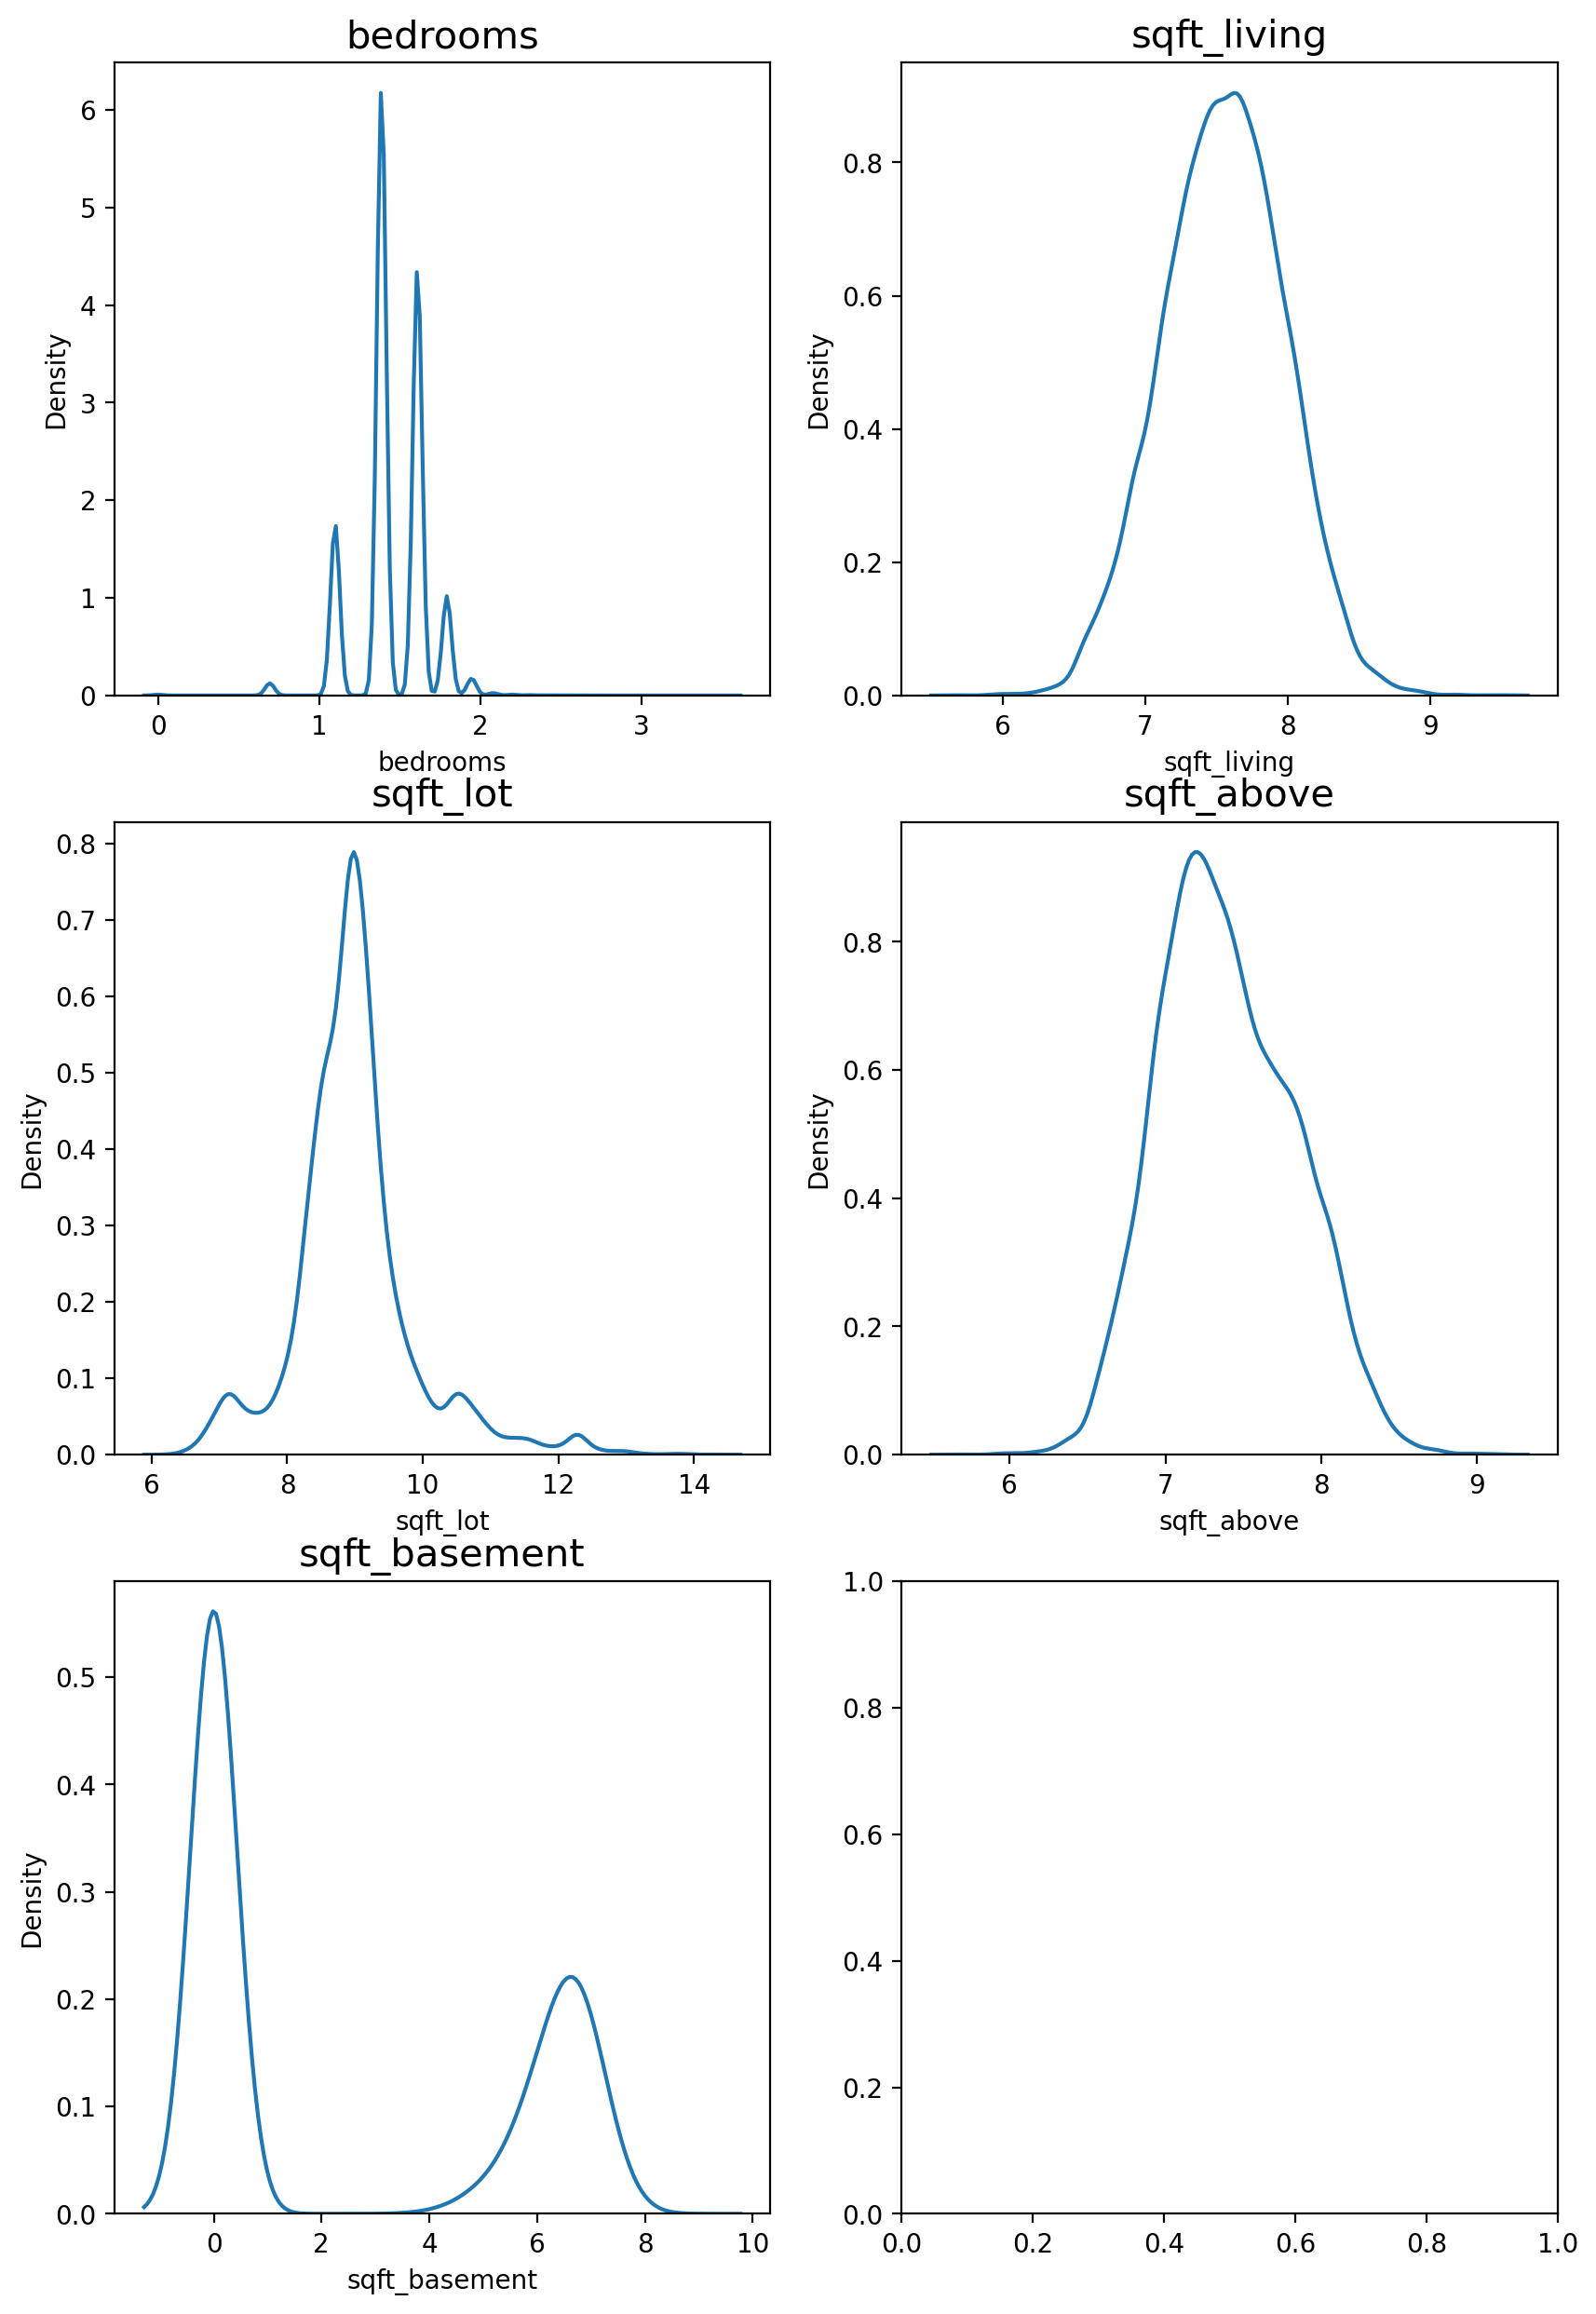

In [18]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1



Ïñ¥ÎäêÏ†ïÎèÑ ÏπòÏö∞Ïπ®Ïù¥ Ï§ÑÏñ¥Îì† Î∂ÑÌè¨Î•º ÌôïÏù∏Ìï† Ïàò ÏûàÏäµÎãàÎã§.

In [19]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

## 3. Î™®Îç∏ÎßÅ
### Average Blending
Ïó¨Îü¨Í∞ÄÏßÄ Î™®Îç∏Ïùò Í≤∞Í≥ºÎ•º ÏÇ∞Ïà† ÌèâÍ∑†ÏùÑ ÌÜµÌï¥ Blending Î™®Îç∏ÏùÑ ÎßåÎì§Í≤†ÏäµÎãàÎã§.

In [20]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
ÍµêÏ∞® Í≤ÄÏ¶ùÏùÑ ÌÜµÌï¥ Î™®Îç∏Ïùò ÏÑ±Îä•ÏùÑ Í∞ÑÎã®Ìûà ÌèâÍ∞ÄÌïòÍ≤†ÏäµÎãàÎã§.

In [23]:
def get_cv_score(models):
    #kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    kfold = KFold(n_splits=5, shuffle=True, random_state=2019)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                             kf=kfold))

In [24]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8597
Model XGBoost CV score : 0.8763
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 540497.991270
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2327
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 542956.681826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001443 seconds.
Y

### Make Submission

ÌöåÍ∑Ä Î™®Îç∏Ïùò Í≤ΩÏö∞ÏóêÎäî cross_val_score Ìï®ÏàòÍ∞Ä R<sup>2</sup>Î•º Î∞òÌôòÌï©ÎãàÎã§.<br>
R<sup>2</sup> Í∞íÏù¥ 1Ïóê Í∞ÄÍπåÏö∏ÏàòÎ°ù Î™®Îç∏Ïù¥ Îç∞Ïù¥ÌÑ∞Î•º Ïûò ÌëúÌòÑÌï®ÏùÑ ÎÇòÌÉÄÎÉÖÎãàÎã§. 3Í∞ú Ìä∏Î¶¨ Î™®Îç∏Ïù¥ ÏÉÅÎãπÌûà ÌõàÎ†® Îç∞Ïù¥ÌÑ∞Ïóê ÎåÄÌï¥ Í¥úÏ∞ÆÏùÄ ÏÑ±Îä•ÏùÑ Î≥¥Ïó¨Ï£ºÍ≥† ÏûàÏäµÎãàÎã§.<br> ÌõàÎ†® Îç∞Ïù¥ÌÑ∞ÏÖãÏúºÎ°ú 3Í∞ú Î™®Îç∏ÏùÑ ÌïôÏäµÏãúÌÇ§Í≥†, Average BlendingÏùÑ ÌÜµÌï¥ Ï†úÏ∂ú Í≤∞Í≥ºÎ•º ÎßåÎì§Í≤†ÏäµÎãàÎã§.

In [25]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [26]:
y_pred = AveragingBlending(models, x, y, sub)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 540682.653143


In [27]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [28]:
sub.to_csv('submission.csv', index=False)

In [36]:
data_dir = '~/work/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()


id    date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  201410  221900.0         3       1.00         1180      5650     1.0   
1   1  201502  180000.0         2       1.00          770     10000     1.0   
2   2  201502  510000.0         3       2.00         1680      8080     1.0   
3   3  201406  257500.0         3       2.25         1715      6819     2.0   
4   4  201501  291850.0         3       1.50         1060      9711     1.0   

   waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0           0     0  ...      7        1180              0      1955   
1           0     0  ...      6         770              0      1933   
2           0     0  ...      8        1680              0      1987   
3           0     0  ...      7        1715              0      1995   
4           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [38]:
y = train['price']
del train['price']

print(train.columns)

KeyError: 'price'

In [39]:
del train['id']

In [40]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

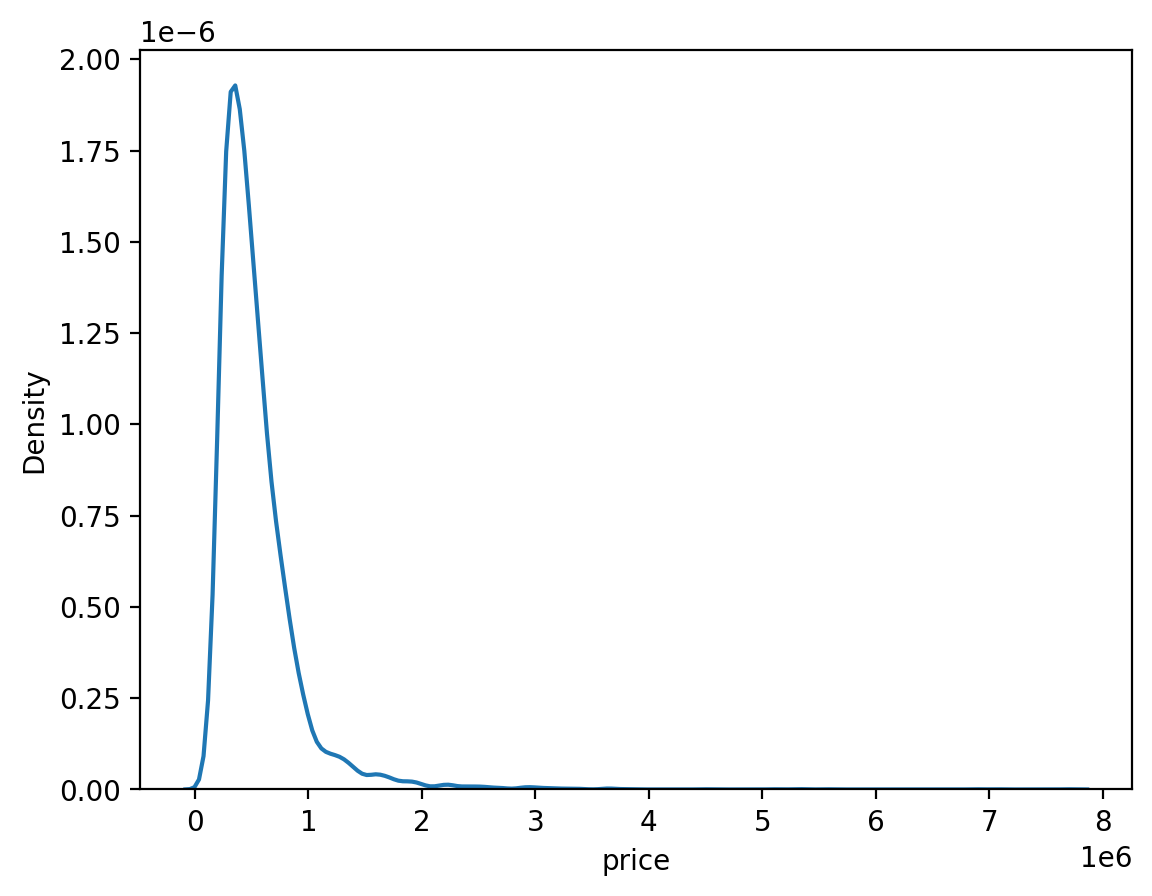

In [41]:
sns.kdeplot(y)
plt.show()

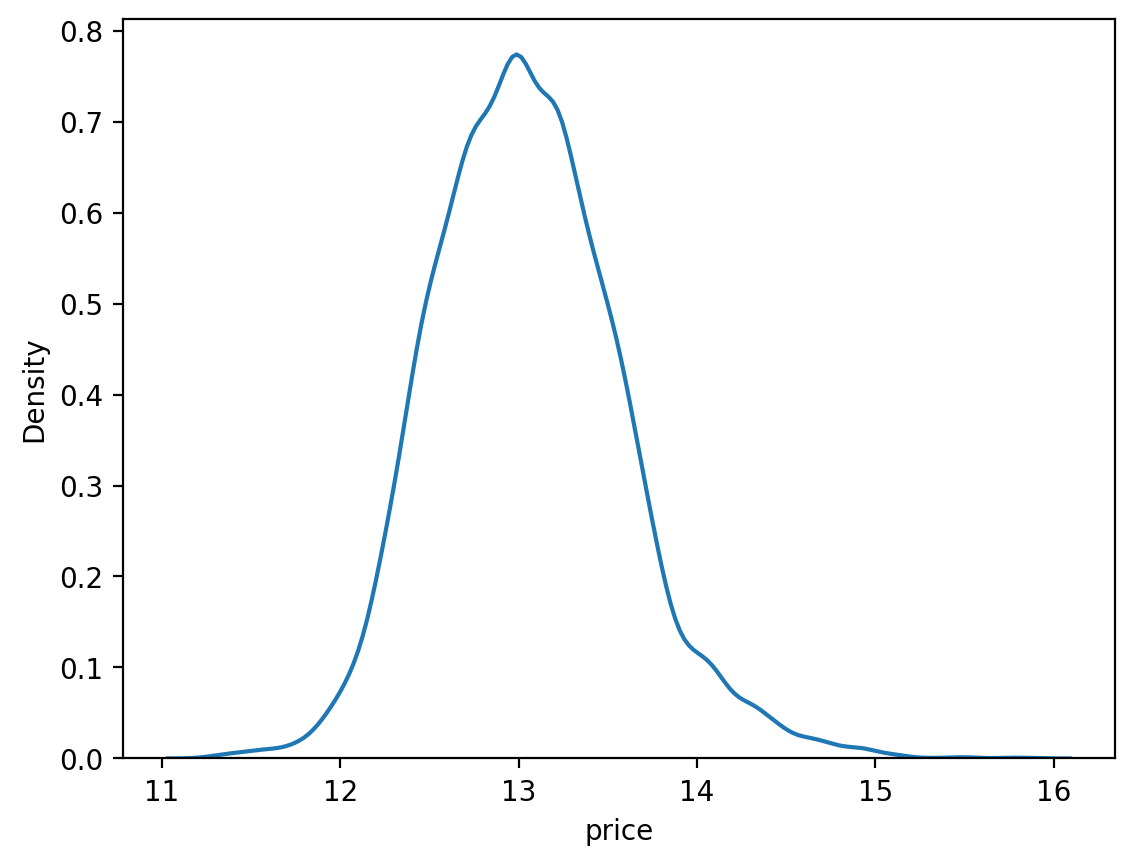

In [42]:
y = np.log1p(y)
y

sns.kdeplot(y)
plt.show()

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print('Ïñçüí¢')

Ïñçüí¢


In [43]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('Ïñçüí¢')

Ïñçüí¢


In [44]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('Ïñçüí¢')

Ïñçüí¢


In [45]:
# random_stateÎäî Î™®Îç∏Ï¥àÍ∏∞ÌôîÎÇò Îç∞Ïù¥ÌÑ∞ÏÖã Íµ¨ÏÑ±Ïóê ÏÇ¨Ïö©ÎêòÎäî ÎûúÎç§ ÏãúÎìúÍ∞íÏûÖÎãàÎã§.
#random_state=None    # Ïù¥Í≤å Ï¥àÍ∏∞Í∞íÏûÖÎãàÎã§. ÏïÑÎ¨¥Í≤ÉÎèÑ ÏßÄÏ†ïÌïòÏßÄ ÏïäÍ≥† NoneÏùÑ ÎÑòÍ≤®Ï£ºÎ©¥ Î™®Îç∏ ÎÇ¥Î∂ÄÏóêÏÑú ÏûÑÏùòÎ°ú ÏÑ†ÌÉùÌï©ÎãàÎã§.
random_state=2020        # ÌïòÏßÄÎßå Ïö∞Î¶¨Îäî Ïù¥Î†áÍ≤å Í≥†Ï†ïÍ∞íÏùÑ ÏÑ∏ÌåÖÌï¥ ÎëêÍ≤†ÏäµÎãàÎã§.

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('Ïñçüí¢')

Ïñçüí¢


In [46]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [48]:
df = {}

for model in models:
    # Î™®Îç∏ Ïù¥Î¶Ñ ÌöçÎìù
    model_name = model.__class__.__name__

    # train, test Îç∞Ïù¥ÌÑ∞ÏÖã Î∂ÑÎ¶¨
    # random_stateÎ•º ÏÇ¨Ïö©ÌïòÏó¨ Í≥†Ï†ïÌïòÍ≥† trainÍ≥º test ÏÖãÏùò ÎπÑÏú®ÏùÄ 8:2Î°ú Ìï©ÎãàÎã§.
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)


    # Î™®Îç∏ ÌïôÏäµ
    model.fit(X_train, y_train)

    # ÏòàÏ∏°
    y_pred = model.predict(X_test)

    # ÏòàÏ∏° Í≤∞Í≥ºÏùò rmseÍ∞í Ï†ÄÏû•
    df[model_name] = rmse(y_test, y_pred)

    # data frameÏóê Ï†ÄÏû•
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

df

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.047779


{'GradientBoostingRegressor': np.float64(128360.19649691365),
 'XGBRegressor': np.float64(117618.22355411823),
 'LGBMRegressor': np.float64(111920.36735892233),
 'RandomForestRegressor': np.float64(125486.94461618949)}

In [51]:
from sklearn.model_selection import GridSearchCV

print('Ïñçüí¢')

Ïñçüí¢


In [62]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [52]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [53]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [54]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.17974603, -0.17912826, -0.03543716, -0.03523136])

In [55]:
results = pd.DataFrame(params)
results['score'] = score

results

max_depth  n_estimators     score
0          1            50 -0.179746
1          1           100 -0.179128
2         10            50 -0.035437
3         10           100 -0.035231

In [57]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results = results.rename(columns={'RMSE': 'RMSLE'})
results = results.sort_values('RMSLE')
results



max_depth  n_estimators     score     RMSLE
3         10           100 -0.035231  0.187700
2         10            50 -0.035437  0.188248
1          1           100 -0.179128  0.423235
0          1            50 -0.179746  0.423965

In [61]:
"""
Îã§ÏùåÍ≥º Í∞ôÏùÄ Í≥ºÏ†ïÏùÑ ÏßÑÌñâÌï† Ïàò ÏûàÎäî `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` Ìï®ÏàòÎ•º Íµ¨ÌòÑÌï¥ Î≥¥ÏÑ∏Ïöî.

1. GridSearchCV Î™®Îç∏Î°ú `model`ÏùÑ Ï¥àÍ∏∞ÌôîÌï©ÎãàÎã§.
2. Î™®Îç∏ÏùÑ fitting Ìï©ÎãàÎã§.
3. params, scoreÏóê Í∞Å Ï°∞Ìï©Ïóê ÎåÄÌïú Í≤∞Í≥ºÎ•º Ï†ÄÏû•Ìï©ÎãàÎã§.
4. Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑÏùÑ ÏÉùÏÑ±ÌïòÍ≥†, RMSLE Í∞íÏùÑ Ï∂îÍ∞ÄÌïú ÌõÑ Ï†êÏàòÍ∞Ä ÎÜíÏùÄ ÏàúÏÑúÎ°ú Ï†ïÎ†¨Ìïú `results`Î•º Î∞òÌôòÌï©ÎãàÎã§.
"""

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV Î™®Îç∏Î°ú Ï¥àÍ∏∞Ìôî
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # Î™®Îç∏ fitting
    grid_model.fit(train, y)

    # Í≤∞Í≥ºÍ∞í Ï†ÄÏû•
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑ ÏÉùÏÑ±
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE Í∞í Í≥ÑÏÇ∞ ÌõÑ Ï†ïÎ†¨
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [63]:
param_grid = {
    'n_estimators': [20, 50, 100, 150],
    'max_depth': [1, 5, 10, 20],
}

#Í∑∏Î¶¨ÎìúÎ•º Ï∂îÍ∞ÄÌïòÏó¨ Îçî ÏµúÏ†ÅÏùò Ï°∞Ìï©ÏùÑ Ï∞æÎèÑÎ°ù Ìï¥Î¥§Îã§

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2331
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.051670
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

max_depth  n_estimators     score     RMSLE
11         10           150 -0.026458  0.162660
15         20           150 -0.026460  0.162666
10         10           100 -0.027027  0.164399
14         20           100 -0.027051  0.164472
7           5           150 -0.027708  0.166456
6           5           100 -0.028797  0.169696
9          10            50 -0.029177  0.170814
13         20            50 -0.029198  0.170875
5           5            50 -0.031783  0.178277
8          10            20 -0.042871  0.207053
12         20            20 -0.042871  0.207053
4           5            20 -0.045691  0.213755
3           1           150 -0.048428  0.220064
2           1           100 -0.055020  0.234564
1           1            50 -0.073394  0.270914
0           1            20 -0.116005  0.340596

In [64]:
model = LGBMRegressor(max_depth=10, n_estimators=150, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122


array([13.11590791, 13.07124691, 14.12791796, ..., 13.0370532 ,
       12.71430206, 12.97328079], shape=(6468,))

In [65]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction = np.expm1(prediction)

prediction

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122


array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302],
      shape=(6468,))

In [66]:
data_dir = '~/work/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = prediction
submission.head()

id         price
0  15035  5.067667e+05
1  15036  4.795061e+05
2  15037  1.345155e+06
3  15038  3.122579e+05
4  15039  3.338645e+05

In [67]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

~/work/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


![Ï†úÏ∂úÌôïÏù∏Ïö©](./pictures/kaggle.png)